# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [41]:
import csv # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text),training=True),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [44]:
def parse_data_line(data_line):
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)

    label=data_line[1]
    statement = data_line[2]
    # Check if the label is either "positive" or "negative" and convert it to lowercase
    label = label.strip().lower()
    if label in ("positive", "negative"):
        return (label, statement)
    return (None, None)

In [45]:
import re

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS

    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    tokens = re.split(r"\s+",text)
    # normalisation - only by lower casing for now
    tokens = [t.lower() for t in tokens]
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [46]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens, training=False):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS

    i = 0
    featureVector = {}
    for w in tokens:
        try:
            # if the word w is in the dictionary,
            # then assign i to its value in the dictionary
            i = global_feature_dict[w]
        except KeyError:
            # else if it's not in the dictionary,
            # it's a new feature in training, add new entry
            if training:
                i = len(global_feature_dict) + 1
                global_feature_dict[w] = i
            else:
                # At test time don't add new entry
                i = global_feature_dict["<unk/>"]  # get the special unknown word token

        try:
            # if the word w is in the local feature vector (repeat word), add 1/n weight
            featureVector[i] += 1 #(1.0/len(words))
        except KeyError:
            # else if it's not in the local feature vector, create the entry with 1/n weight
            featureVector[i] = 1 #(1.0/len(words))

    return featureVector

# start by using binary feature values; 1 if the feature is present, by default the sklearn learn vectorization function will give it 0 if it’s not.
# def to_feature_vector(tokens, training=False):
#     featureVector = {}
#     i = 0
#     for w in tokens:
#         try:
#             i = global_feature_dict[w]
#         except KeyError:
#             if training:
#                 i = len(global_feature_dict) + 1
#                 global_feature_dict[w] = i
#             else:
#                 i = global_feature_dict["<unk/>"]

#         try:
#             # if the word w is in the local feature vector (repeat word), weight could simply be 1 for each word
#             featureVector[i] = 1
#         except KeyError:
#             # else if it's not in the local feature vector, create the entry with 1/n weight
#             featureVector[i] = 0

#     return featureVector


global_feature_dict["<unk/>"] = len(global_feature_dict)+1

In [47]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(dual=False))])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [48]:
#solution
# the package sklearn.metrics contains many utilities for evaluation metrics - try precision, recall, fscore, support to start with
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def cross_validate(dataset, folds):
    results = []
    all_accuracy = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

        # create training and test data for each fold
        test_start = i
        test_end = min(i + fold_size, len(dataset))
        test_set = dataset[test_start:test_end]
        train_set = dataset[:test_start] + dataset[test_end:]

        # Make use of the given functions train_classifier() and predict_labels() to do the cross-validation
        # train the classifier on the larger training part, and test on the smaller test part.
        classifier = train_classifier(train_set)
        test_true = [t[1] for t in test_set]
        test_pred = predict_labels([x[0] for x in test_set], classifier)

        # get the precision, recall, f1 score, and accuracy of classifier in a variable cv_results, which should contain average scores for all folds and be returned by this function
        report = classification_report(test_true, test_pred, output_dict=True)
        results.append(report)
        print(report)


In [49]:
# PREDICTING LABELS GIVEN A CLASSIFIER
def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

In [50]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
# data_file_path = 'sentiment-dataset.tsv'
data_file_path = '/content/drive/MyDrive/nlp/sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
55395


In [51]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Training Classifier...
{'negative': {'precision': 0.7925033467202142, 'recall': 0.7237163814180929, 'f1-score': 0.7565495207667732, 'support': 818}, 'positive': {'precision': 0.8833247289623128, 'recall': 0.9169346195069668, 'f1-score': 0.8998159347883249, 'support': 1866}, 'accuracy': 0.8580476900149031, 'macro avg': {'precision': 0.8379140378412635, 'recall': 0.8203255004625298, 'f1-score': 0.8281827277775491, 'support': 2684}, 'weighted avg': {'precision': 0.8556451869824183, 'recall': 0.8580476900149031, 'f1-score': 0.8561527728398788, 'support': 2684}}
Fold start on items 2684 - 5368
Training Classifier...
{'negative': {'precision': 0.6700507614213198, 'recall': 0.6677908937605397, 'f1-score': 0.668918918918919, 'support': 593}, 'positive': {'precision': 0.9058767319636885, 'recall': 0.9067431850789096, 'f1-score': 0.9063097514340345, 'support': 2091}, 'accuracy': 0.8539493293591655, 'macro avg': {'precision': 0.7879637466925041, 'recall': 0.7872670394

# Question 4: Error Analysis (20 marks)

In [52]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


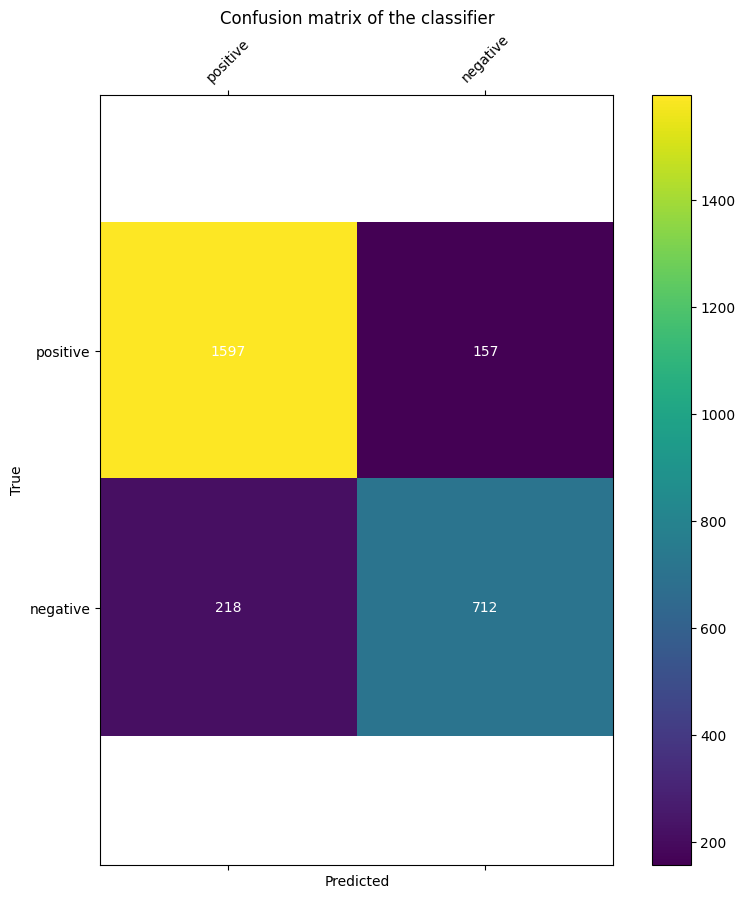

              precision    recall  f1-score   support

    positive       0.82      0.77      0.79       930
    negative       0.88      0.91      0.89      1754

    accuracy                           0.86      2684
   macro avg       0.85      0.84      0.84      2684
weighted avg       0.86      0.86      0.86      2684



In [53]:
# Carry out an error analysis on a simple train-test split of the training data (e.g. the first fold from cross-validation function)
train_train_data=[]
train_test_data=[]
labels=["positive", "negative"]
num_samples = len(train_data)
num_training_samples = int((0.9 * num_samples))
for (text, label) in train_data[:num_training_samples]:
    train_train_data.append((text,label))
for (text, label) in train_data[num_training_samples:]:
    train_test_data.append((text,label))

classifier = train_classifier(train_train_data)
train_test_true = [t[1] for t in train_test_data]
train_test_pred = predict_labels([x[0] for x in train_test_data], classifier)
confusion_matrix_heatmap(train_test_true, train_test_pred, labels)

print(metrics.classification_report(train_test_true, train_test_pred,
                                    target_names=labels))

In [54]:
# # print out (or better, print to file) all the false positives and false negatives for the positive label to try to understand why the classifier is not getting these correct
with open('false_positive.txt', 'a') as file:
    file.write("False Positives:\n")

    # Error analysis of False Positives TODO
    for doc, label in zip(train_test_data, train_test_true):
        prediction = train_test_pred[train_test_data.index(doc)]  # Find index based on doc

        if label not in labels:  # only focus on the target categories
            continue
        if prediction == label:  # correct/TP, ignore these
            continue
        if label == 'positive' and label != prediction:
            file.write('**** FALSE POSITIVE for {1} (ground truth = {2}):****\n\n {0}\n'.format(doc, prediction, label))
            file.write('*' * 50 + '\n')  # Add a line break after each false positive entry


In [55]:
# # # Error analysis of False Negatives
with open('false_negative.txt', 'a') as file:
    file.write("False negative:\n")

    # Error analysis of False Positives TODO
    for doc, label in zip(train_test_data, train_test_true):
        prediction = train_test_pred[train_test_data.index(doc)]  # Find index based on doc

        if label not in labels:  # only focus on the target categories
            continue
        if prediction == label:  # correct/TP, ignore these
            continue
        if label != 'positive' and label != prediction:
            file.write('**** FALSE NEGATIVE for {1} (ground truth = {2}):****\n\n {0}\n'.format(doc, prediction, label))
            file.write('*' * 50 + '\n')  # Add a line break after each false positive entry


# Questions 5: Optimising pre-processing and feature extraction (30 marks)

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [56]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({105: 1, 226: 2, 6: 2, 750: 2, 1050: 1, 60: 2, 30050: 1, 96: 1, 59: 1, 1: 3, 287: 1, 979: 1, 110: 2, 172: 1, 148: 1, 19090: 1, 24: 1, 2778: 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.852547
Recall: 0.853757
F Score:0.852916
